# Plots

> Core Plotting Functions

In [ ]:
#| default_exp _plotting/core

In [ ]:
#| export
#| echo: false
import matplotlib.pyplot as plt
try:
    plt.rcParams["font.family"] = "Arial"
except Exception:
    pass

import matplotlib.dates as mdates
from matplotlib.ticker import (
    FormatStrFormatter, FuncFormatter)

import pandas as pd
import numpy as np
import seaborn as sns
from hypersheets import (
    stats, utils)

In [ ]:
#| export
#| echo: false
# Define global color variables
sns.set(font_scale=1.1, rc={
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#333333',
    'xtick.color': '#666666',
    'ytick.color': '#666666'
})

FLATUI_COLORS = ["#696969", "#348dc1", "#af4b64",#fedd78->#696969 #348dc1->#0000FF
                  "#4fa487", "#9b59b6", "#808080"]
GRAYSCALE_COLORS = ['silver', '#222222', 'gray'] * 3

In [ ]:
#| export
def _get_colors(grayscale):
    """Utility function to get colors"""
    colors = FLATUI_COLORS
    ls = '-'
    alpha = .8
    if grayscale:
        colors = GRAYSCALE_COLORS
        ls = '-'
        alpha = 0.5
    return colors, ls, alpha
    
def format_cur_axis(x, _):
    if x >= 1e12:
        res = '$%1.1fT' % (x * 1e-12)
        return res.replace('.0T', 'T')
    if x >= 1e9:
        res = '$%1.1fB' % (x * 1e-9)
        return res.replace('.0B', 'B')
    if x >= 1e6:
        res = '$%1.1fM' % (x * 1e-6)
        return res.replace('.0M', 'M')
    if x >= 1e3:
        res = '$%1.0fK' % (x * 1e-3)
        return res.replace('.0K', 'K')
    res = '$%1.0f' % x
    return res.replace('.0', '')


def format_pct_axis(x, _):
    x *= 100  # lambda x, loc: "{:,}%".format(int(x * 100))
    if x >= 1e12:
        res = '%1.1fT%%' % (x * 1e-12)
        return res.replace('.0T%', 'T%')
    if x >= 1e9:
        res = '%1.1fB%%' % (x * 1e-9)
        return res.replace('.0B%', 'B%')
    if x >= 1e6:
        res = '%1.1fM%%' % (x * 1e-6)
        return res.replace('.0M%', 'M%')
    if x >= 1e3:
        res = '%1.1fK%%' % (x * 1e-3)
        return res.replace('.0K%', 'K%')
    res = '%1.0f%%' % x
    return res.replace('.0%', '%')

In [ ]:
#| export
def plot_returns_bars(returns, benchmark=None,
                      returns_label="Strategy", benchmark_label="Benchmark",
                      hline=None, hlw=None, hlcolor="red", hllabel="",
                      resample="A", title="Returns", match_volatility=False,
                      log_scale=False, figsize=(10, 6),
                      grayscale=False, fontname='Arial', ylabel=True,
                      subtitle=True, savefig=None, show=True):

    if match_volatility and benchmark is None:
        raise ValueError('match_volatility requires passing of '
                         'benchmark.')
    if match_volatility and benchmark is not None:
        bmark_vol = benchmark.loc[returns.index].std()
        returns = (returns / returns.std()) * bmark_vol

    # ---------------
    colors, _, _ = _get_colors(grayscale)
    df = pd.DataFrame(index=returns.index, data={returns_label: returns})
    if isinstance(benchmark, pd.Series):
        df[benchmark_label] = benchmark[benchmark.index.isin(returns.index)]
        df = df[[benchmark_label, returns_label]]

    df = df.dropna()
    if resample is not None:
        df = df.resample(resample).apply(
            stats.comp).resample(resample).last()
    # ---------------

    fig, ax = plt.subplots(figsize=figsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # use a more precise date string for the x axis locations in the toolbar
    fig.suptitle(title+"\n", y=.99, fontweight="bold", fontname=fontname,
                 fontsize=14, color="black")

    if subtitle:
        ax.set_title("\n%s - %s                   " % (
            df.index.date[:1][0].strftime('%Y'),
            df.index.date[-1:][0].strftime('%Y')
        ), fontsize=12, color='gray')

    if benchmark is None:
        colors = colors[1:]
    df.plot(kind='bar', ax=ax, color=colors)

    fig.set_facecolor('white')
    ax.set_facecolor('white')

    try:
        ax.set_xticklabels(df.index.year)
        years = sorted(list(set(df.index.year)))
    except AttributeError:
        ax.set_xticklabels(df.index)
        years = sorted(list(set(df.index)))

    # ax.fmt_xdata = _mdates.DateFormatter('%Y-%m-%d')
    # years = sorted(list(set(df.index.year)))
    if len(years) > 10:
        mod = int(len(years)/10)
        plt.xticks(np.arange(len(years)), [
            str(year) if not i % mod else '' for i, year in enumerate(years)])

    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()

    if hline:
        if grayscale:
            hlcolor = 'gray'
        ax.axhline(hline, ls="--", lw=hlw, color=hlcolor,
                   label=hllabel, zorder=2)

    ax.axhline(0, ls="--", lw=1, color="#000000", zorder=2)

    if isinstance(benchmark, pd.Series) or hline:
        ax.legend(fontsize=12)

    plt.yscale("symlog" if log_scale else "linear")

    ax.set_xlabel('')
    if ylabel:
        ax.set_ylabel("Returns", fontname=fontname,
                      fontweight='bold', fontsize=12, color="black")
        ax.yaxis.set_label_coords(-.1, .5)

    ax.yaxis.set_major_formatter(FuncFormatter(format_pct_axis))

    try:
        plt.subplots_adjust(hspace=0, bottom=0, top=1)
    except Exception:
        pass

    try:
        fig.tight_layout()
    except Exception:
        pass

    if savefig:
        if isinstance(savefig, dict):
            plt.savefig(**savefig)
        else:
            plt.savefig(savefig)

    if show:
        plt.show(block=False)

    plt.close()

    if not show:
        return fig

    return None

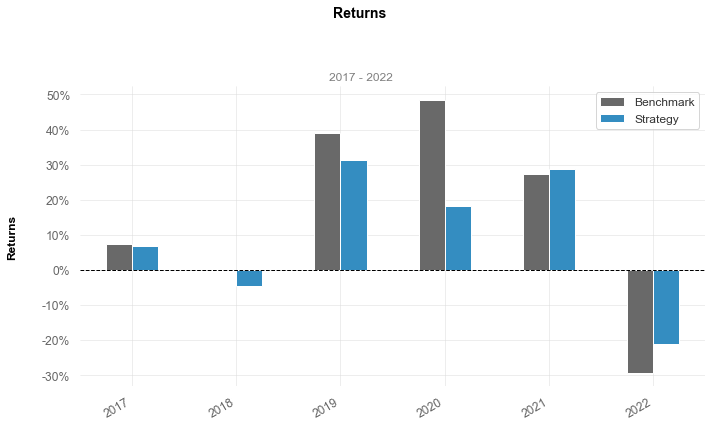

In [ ]:
#| eval: false
returns = utils.download_returns('SPY', '5y')
benchmark = utils.download_returns('QQQ', '5y')
plot_returns_bars(returns, benchmark)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()